In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import sklearn.pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from scipy.stats import norm
seed = 222
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.dpi'] = 80


In [2]:
d = pd.read_csv('data.csv')
d.describe()

,x,z,y
count,100.000000,100.000000,100.000000
mean,-0.204684,0.320000,0.574631
std,3.631220,0.468826,2.322334
min,-5.957644,0.000000,-2.450962
25%,-3.561928,0.000000,-0.786199
50%,0.169621,0.000000,0.120662
75%,2.493672,1.000000,1.303140
max,6.240632,1.000000,11.466062


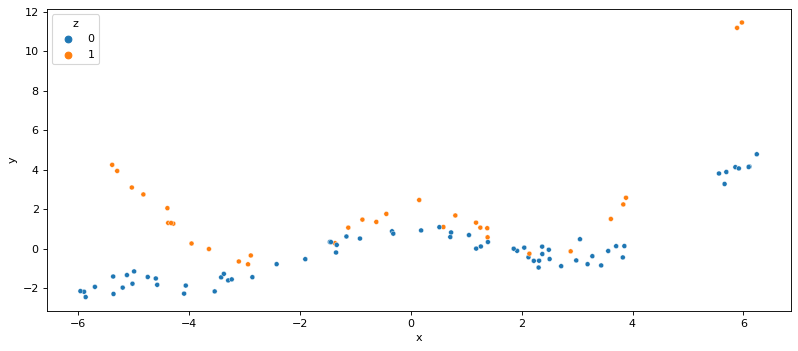

In [3]:
sns.scatterplot(x='x', y='y', data = d, hue= 'z', s=20)
plt.savefig('Plots/my_data.pdf')
plt.show()

In [4]:
def create_design_matrix(x,z):
    
    X = np.vstack((z, np.cos(x), z * np.cos(x), x, z * x, x * x, 
    z * x * x, x * x * x, z * x * x * x ))
    X = X.T
    return(X)
    
X =create_design_matrix(d.x, d.z)
y = d.y


In [5]:
def get_coefs(m):
    if (isinstance(m, sklearn.pipeline.Pipeline)): 
        m = m.steps[-1][1]
    if m.intercept_ is None: 
        return m.coef_
    return np.concatenate([[m.intercept_], m.coef_])


In [6]:
def model_fit(m, X, y, plot = False):

    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    res = pd.DataFrame(
            data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    if plot:
            plt.figure(figsize=(12, 6))
            plt.subplot(121)
            sns.lineplot(x='y', y='y_hat', color="grey", data = pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
            sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
            plt.subplot(122)
            sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
            plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
            plt.savefig('Plots/model_summary.pdf')
            plt.show()
    return(rmse)
    

In [7]:
r = make_pipeline(
    Ridge(alpha=1)
).fit(X, y)

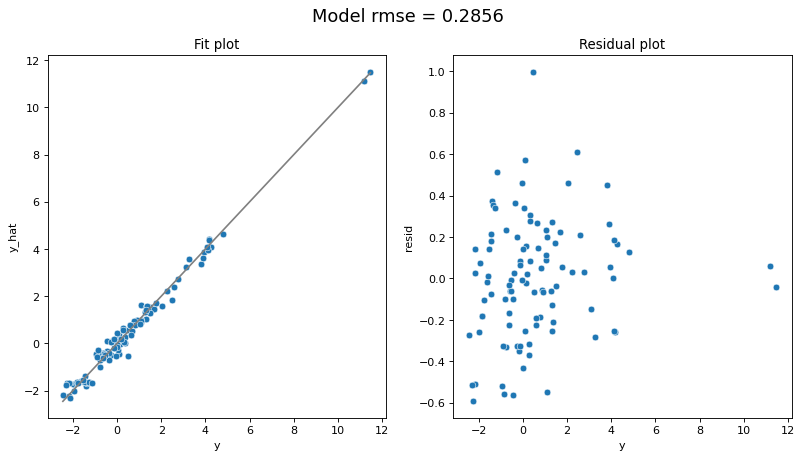

0.28562723450347427

In [8]:
model_fit(r, X, y, plot=True)

In [9]:
alphas = np.linspace(0.01, 5, num=150)

gs = GridSearchCV(
    make_pipeline(
        Ridge()
        ),
        param_grid={'ridge__alpha': alphas}, 
        cv=KFold(5, shuffle=True, random_state=1234), 
        scoring="neg_root_mean_squared_error"
).fit(X, y)

{'ridge__alpha': 1.2156375838926177}


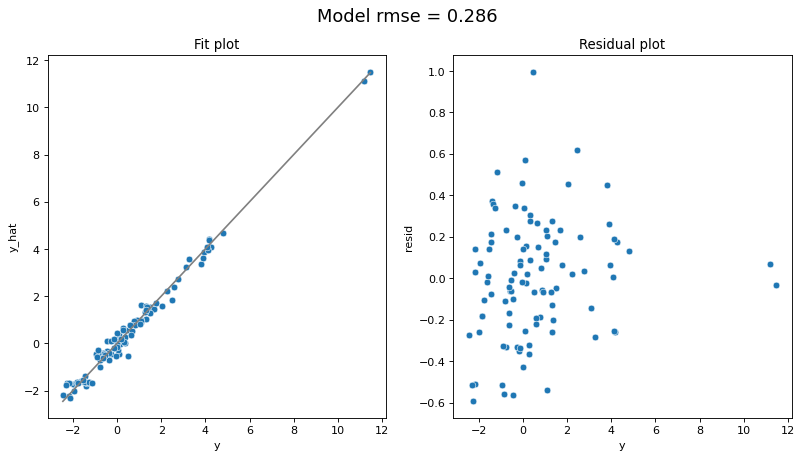

In [10]:
print(gs.best_params_)
model_fit(gs.best_estimator_, X, y, plot=True)
best_alpha = gs.best_params_['ridge__alpha']

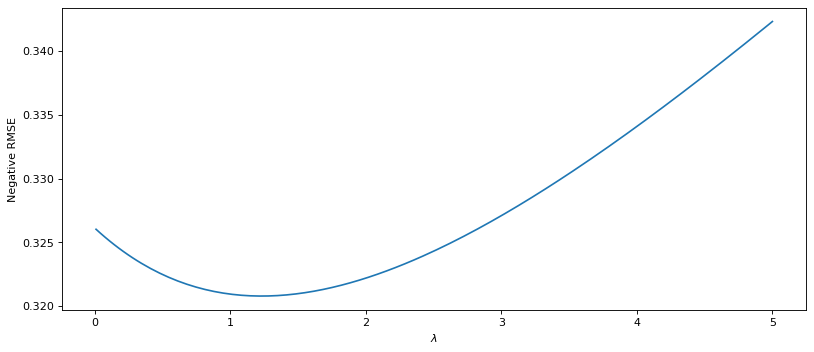

In [11]:
cv_res = pd.DataFrame(
    data = gs.cv_results_
).filter(
    regex = '(split[0-9]+|mean)_test_score'
).assign(
# Add the alphas as a column 
    alpha = alphas
)
cv_res.update(
# Convert negative rmses to positive
-1 * cv_res.filter(regex = '_test_score')
)
sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
plt.xlabel('$\lambda$')
plt.ylabel('Negative RMSE')
# plt.savefig('Plots/single_l.pdf')
plt.show()

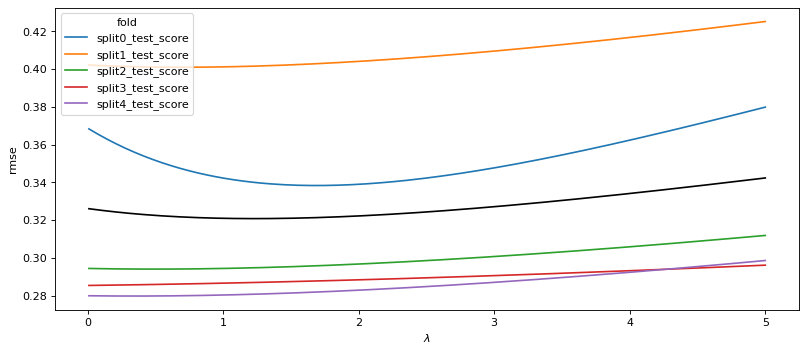

In [12]:
d1 = cv_res.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='rmse'
)

sns.lineplot(x='alpha', y='rmse', color='black', ci = None, data = d1) # Plot␣ 􏰫→the mean rmse +/- the std dev of the rmse.
sns.lineplot(x='alpha', y='rmse', hue='fold', data = d1) # Plot the curves for␣ 􏰫→each fold
plt.xlabel('$\lambda$')
# plt.savefig('Plots/splits.pdf')
plt.show()

In [13]:
m = make_pipeline(
    Ridge(alpha=best_alpha, fit_intercept = False, solver='svd' )
).fit(X, y)

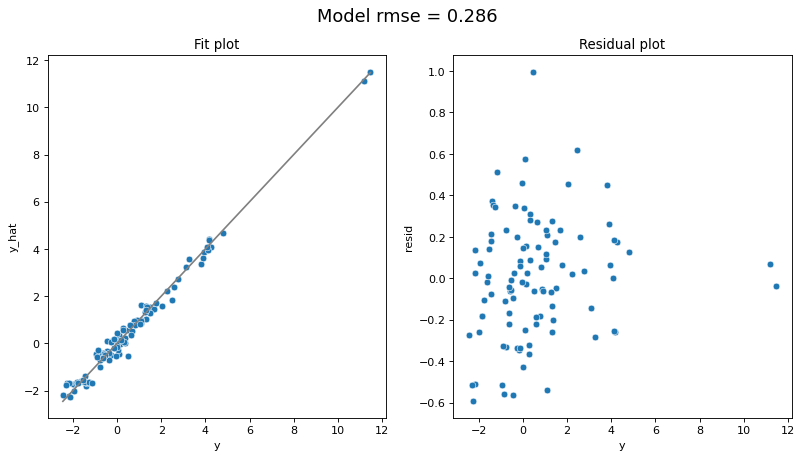

0.2860400200263679

In [14]:
model_fit(m, X, y, plot= True)

In [15]:
new_x = np.arange(-7, 7.1, step=0.1)

X_new1 = create_design_matrix(new_x, np.zeros(new_x.shape))
X_new2 = create_design_matrix(new_x, np.ones(new_x.shape))

In [16]:
y_hat1 = m.predict(X_new1)
y_hat2 = m.predict(X_new2)


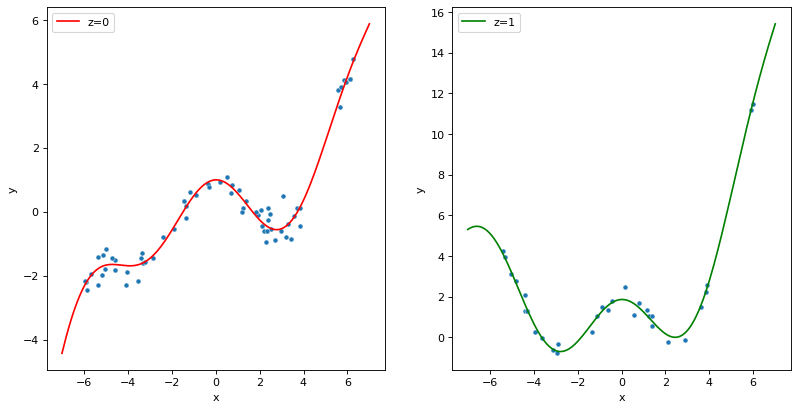

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x='x', y='y', data = d[d.z == 0], s=20)
plt.plot(new_x, y_hat1, color = 'red', label ='z=0')
plt.legend()
plt.subplot(122)
sns.scatterplot(x='x', y='y', data = d[d.z == 1], s=20)
plt.plot(new_x, y_hat2, color = 'green', label='z=1')
plt.legend()
# plt.savefig('Plots/two_models_ridge.pdf')
plt.show()

## Part 2

In [18]:
sigma_sq = 0.1

In [19]:
# see equations page 31 of slides
def solve_posterior(
    X: np.ndarray, y: np.ndarray, sigma_sq: np.ndarray, alpha: np.ndarray
) -> np.ndarray:
    n = X.shape[0]
    p = X.shape[1]
    mu = np.linalg.solve(X.T @ X + sigma_sq / alpha * np.eye(p), X.T @ y)
    Sigma = sigma_sq * np.linalg.solve(
        X.T @ X + (sigma_sq / alpha) * np.eye(p), np.eye(p)
    )
    return mu, Sigma

In [20]:
alphas = np.linspace(0.001, 0.2, 150)
mus = np.empty((alphas.shape[0], 9))
for i, a in enumerate(alphas):
    mus[i] = solve_posterior(X, y, sigma_sq, a)[0]
mus.shape


(150, 9)

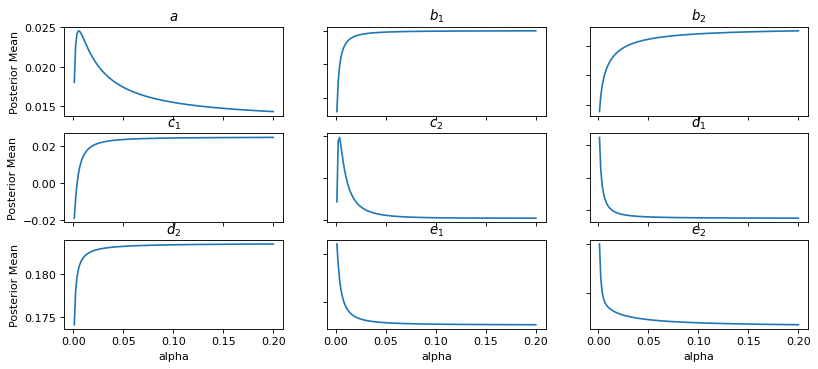

In [21]:
my_lst = [(0,0), (0,1), (0,2), (1,0), (1, 1), (1,2), (2,0), (2,1), (2,2)]
all_par = ['$a$', '$b_1$', '$b_2$', '$c_1$', '$c_2$', '$d_1$', '$d_2$', '$e_1$', '$e_2$']
fig, axs = plt.subplots(3, 3)
for i, (t, p) in enumerate(zip(my_lst, all_par)):
    axs[t].plot(alphas, mus[:,i])
    axs[t].set_title(p)

for ax in axs.flat:
    ax.set(xlabel='alpha', ylabel='Posterior Mean')

for ax in axs.flat:
    ax.label_outer()

# fig.savefig('Plots/all_par.pdf')

In [22]:
mu, sigma = solve_posterior(X, y, sigma_sq, 1)

In [23]:
pred_1 = X_new1 @ mu 
pred_2 = X_new2 @ mu 
pred_1_var = X_new1 @ sigma @ X_new1.T + sigma_sq
pred_1_var = X_new2 @ sigma @ X_new2.T + sigma_sq

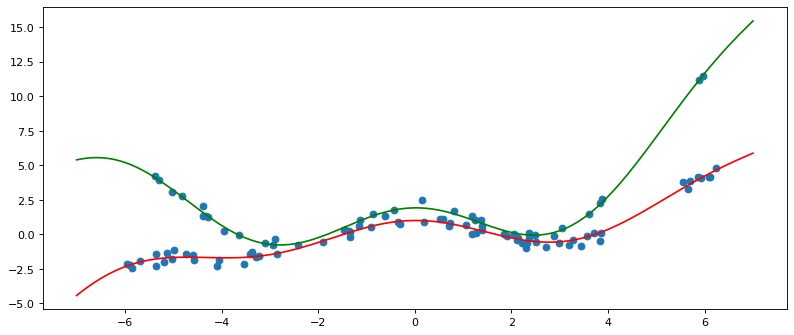

In [24]:
plt.scatter(d.x,d.y)
plt.plot(new_x, pred_1, color = 'red')
plt.plot(new_x, pred_2, color = 'green')


In [25]:
cred_int_1 = np.empty((X_new1.shape[0],2))
for i in range(0, X_new1.shape[0]):
    big_sigma = X_new1[i] @ sigma @ X_new1[i].T + sigma_sq
    cred_int_1[i,0] = norm.ppf(0.025, pred_1[i], big_sigma)
    cred_int_1[i,1] = norm.ppf(0.975, pred_1[i], big_sigma)

cred_int_2 = np.empty((X_new2.shape[0],2))
for i in range(0, X_new2.shape[0]):
    big_sigma = X_new2[i] @ sigma @ X_new2[i].T + sigma_sq
    cred_int_2[i,0] = norm.ppf(0.025, pred_2[i], big_sigma)
    cred_int_2[i,1] = norm.ppf(0.975, pred_2[i], big_sigma)

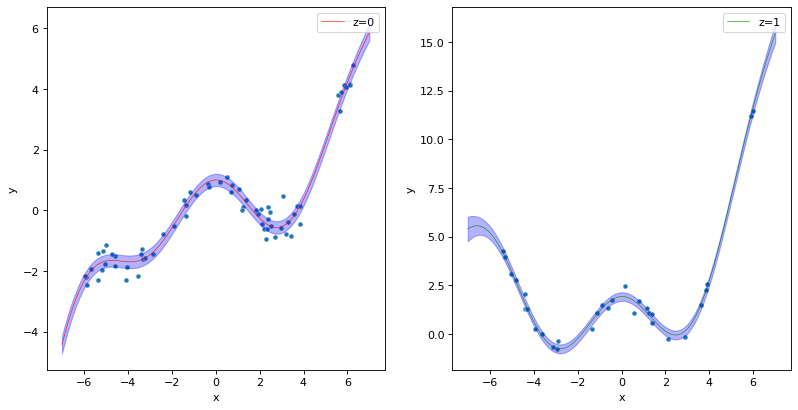

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x='x', y='y', data = d[d.z == 0], s=20)
plt.plot(new_x, pred_1, color = 'red', linewidth=0.5, label='z=0')
plt.fill_between(new_x, cred_int_1[:,0], cred_int_1[:,1], alpha=0.3, color='blue')
plt.legend()
plt.subplot(122)
sns.scatterplot(x='x', y='y', data = d[d.z == 1], s=20)
plt.plot(new_x, pred_2, color = 'green', linewidth=0.5, label='z=1')
plt.fill_between(new_x, cred_int_2[:,0], cred_int_2[:,1], alpha=0.3, color='blue')
plt.legend()
# plt.savefig('Plots/two_models_bayes.pdf')
plt.show()

In [27]:
X_trial = create_design_matrix(np.array([-5,7, -5, 7]), np.array([0,1, 1,0]))

In [28]:
pred_bayesian1 = X_trial @ mu

pred_ridge = m.predict(X_trial)

In [29]:
ridge_alpha = sigma_sq / best_alpha
ridge_alpha

0.08226135924474133

In [30]:
def calc_all(i):
    new_mu = solve_posterior(X,y,sigma_sq,0.001)[0]
    new_sigma =  solve_posterior(X,y,sigma_sq,0.001)[1]
    mean_small = X_trial[i] @ new_mu
    sigma_small = X_trial[i] @ new_sigma @ X_trial[i].T
    new_mu = solve_posterior(X,y,sigma_sq,1)[0]
    new_sigma =  solve_posterior(X,y,sigma_sq,1)[1]
    mean_medium = X_trial[i] @ new_mu
    sigma_medium = X_trial[i] @ new_sigma @ X_trial[i].T
    new_mu = solve_posterior(X,y,sigma_sq,ridge_alpha)[0]
    new_sigma =  solve_posterior(X,y,sigma_sq,ridge_alpha)[1]
    mean_ridge = X_trial[i] @ new_mu
    sigma_ridge = X_trial[i] @ new_sigma @ X_trial[i].T
    return(mean_small, sigma_small, mean_medium, sigma_medium, mean_ridge, sigma_ridge)

Text(0.5, 0, '$y^*$')

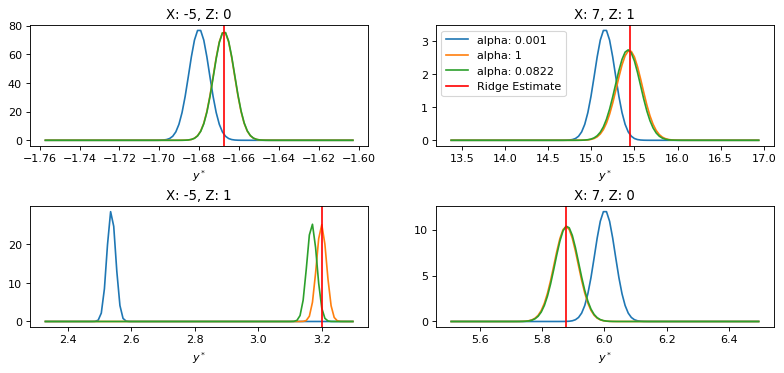

In [31]:
plt.subplots_adjust(hspace=0.5)

plt.subplot(221)
mean_small, sigma_small, mean_medium, sigma_medium, mean_ridge, sigma_ridge = calc_all(0)
t1 = np.linspace(mean_small - 15*sigma_small, mean_small + 15*sigma_small, 100)
plt.plot(t1, norm.pdf(t1, mean_small, sigma_small),label='alpha: 0.001' )
plt.plot(t1, norm.pdf(t1, mean_medium, sigma_medium), label='alpha: 1')
plt.plot(t1, norm.pdf(t1, mean_ridge, sigma_ridge),label='alpha: 0.0822' )
plt.axvline(x=pred_bayesian1[0], color='red', label ='Ridge Estimate')
plt.xlabel('$y^*$')
plt.title('X: -5, Z: 0')
# plt.legend()

plt.subplot(222)
mean_small, sigma_small, mean_medium, sigma_medium, mean_ridge, sigma_ridge = calc_all(1)
t1 = np.linspace(mean_small - 15*sigma_small, mean_small + 15*sigma_small, 100)
plt.plot(t1, norm.pdf(t1, mean_small, sigma_small),label='alpha: 0.001' )
plt.plot(t1, norm.pdf(t1, mean_medium, sigma_medium), label='alpha: 1')
plt.plot(t1, norm.pdf(t1, mean_ridge, sigma_ridge),label='alpha: 0.0822' )
plt.axvline(x=pred_bayesian1[1], color='red', label ='Ridge Estimate')
plt.title('X: 7, Z: 1')
plt.xlabel('$y^*$')

plt.legend()

plt.subplot(223)
mean_small, sigma_small, mean_medium, sigma_medium, mean_ridge, sigma_ridge = calc_all(2)
t1 = np.linspace(mean_small - 15*sigma_small, mean_small + 55*sigma_small, 100)
plt.plot(t1, norm.pdf(t1, mean_small, sigma_small),label='alpha: 0.001' )
plt.plot(t1, norm.pdf(t1, mean_medium, sigma_medium), label='alpha: 1')
plt.plot(t1, norm.pdf(t1, mean_ridge, sigma_ridge),label='alpha: 0.0822' )
plt.axvline(x=pred_bayesian1[2], color='red', label ='Ridge Estimate')
plt.xlabel('$y^*$')

plt.title('X: -5, Z: 1')
# plt.legend()

plt.subplot(224)
mean_small, sigma_small, mean_medium, sigma_medium, mean_ridge, sigma_ridge = calc_all(3)
t1 = np.linspace(mean_small - 15*sigma_small, mean_small + 15*sigma_small, 100)
plt.plot(t1, norm.pdf(t1, mean_small, sigma_small),label='alpha: 0.001' )
plt.plot(t1, norm.pdf(t1, mean_medium, sigma_medium), label='alpha: 1')
plt.plot(t1, norm.pdf(t1, mean_ridge, sigma_ridge),label='alpha: 0.0822' )
plt.axvline(x=pred_bayesian1[3], color='red', label ='Ridge Estimate')
plt.title('X: 7, Z: 0')
plt.xlabel('$y^*$')
# plt.legend()

# plt.savefig('Plots/post_all.pdf')
